# Offline Turbulence Simulations (SCP 10m)

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xr
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy.io as sio

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec

import turbpy

In [2]:
# Project directory
dir_proj = '/Users/karllapo/proj/SnowHydro_OfflineTurb'
dir_print = os.path.join(dir_proj, 'graphics')

# Data
dir_data = os.path.join(dir_proj, 'data')
dir_snq = os.path.join(dir_data, 'SNQ')
dir_scp = os.path.join(dir_data, 'SCP')

# Model output
dir_model_ouptut = os.path.join(dir_data, 'results')

## Get SCP observations

In [3]:
## Read the formatted supporting snoqualmie obs
os.chdir(dir_scp)
Mtower = xr.open_dataset('SCP.Mtower_pottemps.nc')
fluxObs_30m = xr.open_dataset('SCP.flux_obs_30m.netcdf')

In [4]:
## Met variables
scalarGroundSnowFraction  = 1.
soilRelHumidity = 1.

# Turbulence parameters
z0Ground = .005

In [5]:
stab_titles = ['Standard',
               'Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               'MO (Holtslag/de Bruin)',
               'MO (Holtslag/de Bruin - capped)',
               'MO (Beljaars/Holtslag)',
               'MO (Webb - NoahMP)',
               'MO (Cheng/Brutsaert)',
              ]

# Titles for output and xarray datasets
out_titles = {'Standard': 'standard',
               'Louis (b = 4.7)': 'louis',
               'Louis (b = 12)': 'louis_mod',
               'Louis (Ri capped, MJ98)': 'louis_cap',
               'MO (Holtslag/de Bruin)': 'HD88',
               'MO (Holtslag/de Bruin - capped)': 'HD88_cap',
               'MO (Beljaars/Holtslag)': 'BJ91',
               'MO (Webb - NoahMP)': 'webb_noah',
               'MO (Cheng/Brutsaert)': 'CB05',
             }

stab_methods = {'Standard': 'standard',
                'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                'MO (Holtslag/de Bruin)': 'monin_obukhov',
                'MO (Holtslag/de Bruin - capped)': 'monin_obukhov',
                'MO (Beljaars/Holtslag)': 'monin_obukhov',
                'MO (Webb - NoahMP)': 'monin_obukhov',
                'MO (Cheng/Brutsaert)': 'monin_obukhov',
               }

gradient_funcs = {'MO (Holtslag/de Bruin)': 'holtslag_debruin',
                  'MO (Holtslag/de Bruin - capped)': 'holtslag_debruin',
                  'MO (Beljaars/Holtslag)': 'beljaar_holtslag',
                  'MO (Beljaars/Holtslag - capped)': 'beljaar_holtslag',
                  'MO (Cheng/Brutsaert)': 'cheng_brutsaert',
                  'MO (Webb - NoahMP)': 'webb_noahmp',
                 }

params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
           'MO (Holtslag/de Bruin - capped)': 'windless_exchange',
          }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]
    
    # Assigning the gradient method
    if 'monin_obukhov' in stab_methods[st]:
        stab_dict[st]['monin_obukhov'] = {}
        stab_dict[st]['monin_obukhov']['gradient_function'] = gradient_funcs[st]
        stab_dict[st]['monin_obukhov']['roughness_function'] = 'constant_z0'
        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}

z0Ground = 0.0005


## Discriminate data

Only simulate periods that are stable according to the bulk Richardson number at each height.

In [6]:
# Select stable conditions only for offline comparison
ri = turbpy.bulkRichardson(Mtower['theta_10m'] + 273.15, Mtower['Tsfc'] + 273.15, Mtower['UBar_10m'], 10.)
Mtower['RiBulk_10m'] = (('time'), ri)
ind_10m = np.nonzero((Mtower.RiBulk_10m > 0.).values)

In [7]:
offLineCalcFlag = True  # Flag that toggles offline simulation, if False loads previous simulation results
if offLineCalcFlag:  
    ########
    # 10m simulations
    print('-------------------------------------')
    print('Shallow Cold Pool -- 10m Simulation   ')
    print('-------------------------------------')
    print(' ')
    mHeight = 10.
    
    sensible_10m = xr.Dataset()
    sensible_10m.coords['time'] = Mtower.time[ind_10m]
    
    for stab in stab_titles:
        print(stab)

        senHeatGround = np.ones(Mtower.time[ind_10m].size) * np.nan

        # Loop over each time step with snow
        for n, d in enumerate(Mtower.time[ind_10m]):
            if (d['time.hour'].values == 0) & (d['time.minute'].values == 2):
                print(stab + ": " +
                      str(d['time.month'].values) + "/" +
                      str(d['time.day'].values) + "/" +
                      str(d['time.year'].values) +
                      " (" + str(int(n / Mtower.time.size * 100.)) + "%)")
            
            # Met data at Snoqualmie on the given date
            ds = Mtower.sel(time=d)
            snowDepth = 0.  # (m)
            theta_10m = ds.theta_10m + 273.15  # (C) -> (K)
            svp, _ = turbpy.conversionTools.satVapPress(theta_10m)  # Saturation vapor pressure
            airVaporPress = svp # Vapor pressure (Pa)
            windspd = ds.UBar_10m  # (m/s)

            # Surface variables
            sfcTemp = ds.Tsfc + 273.15  # (C) -> (K)
            sfcVaporPress, _ = turbpy.conversionTools.satVapPress(sfcTemp)

            # 1m
            if np.any(np.isnan([snowDepth, theta_10m,
                                sfcTemp, airVaporPress,
                                sfcVaporPress, windspd])):
                continue
            else:
                # Offline Turbulence Package
                (_, _, senHeatGround[n], 
                 _, _, _) = turbpy.turbFluxes(theta_10m, 101000,
                                              airVaporPress, windspd, sfcTemp,
                                              sfcVaporPress, snowDepth,
                                              mHeight, param_dict=stab_dict[stab],
                                              z0Ground=z0Ground)
        
        out_name = out_titles[stab]
        sensible_10m[out_name] = (('time'), senHeatGround)
        
        ########
        # Save sensible/latent offline
        os.chdir(dir_model_ouptut)
        sensible_10m.to_netcdf('TF.SCP.sensible_10m_revision.constant_small_z0.nc')

-------------------------------------
Shallow Cold Pool -- 10m Simulation   
-------------------------------------
 
Standard
Standard: 9/24/2012 (1%)
Standard: 9/26/2012 (2%)
Standard: 10/8/2012 (3%)
Standard: 10/9/2012 (4%)
Standard: 10/10/2012 (5%)
Standard: 10/11/2012 (6%)
Standard: 10/12/2012 (6%)
Standard: 10/13/2012 (7%)
Standard: 10/14/2012 (8%)
Standard: 10/15/2012 (9%)
Standard: 10/16/2012 (10%)
Standard: 10/17/2012 (11%)
Standard: 10/19/2012 (12%)
Standard: 10/20/2012 (13%)
Standard: 10/21/2012 (14%)
Standard: 10/22/2012 (15%)
Standard: 10/23/2012 (16%)
Standard: 10/24/2012 (16%)
Standard: 10/27/2012 (17%)
Standard: 10/28/2012 (18%)
Standard: 10/29/2012 (19%)
Standard: 10/30/2012 (19%)
Standard: 10/31/2012 (20%)
Standard: 11/1/2012 (21%)
Standard: 11/2/2012 (23%)
Standard: 11/3/2012 (24%)
Standard: 11/4/2012 (24%)
Standard: 11/5/2012 (25%)
Standard: 11/6/2012 (26%)
Standard: 11/7/2012 (27%)
Standard: 11/8/2012 (28%)
Standard: 11/9/2012 (29%)
Standard: 11/10/2012 (30%)
Standa

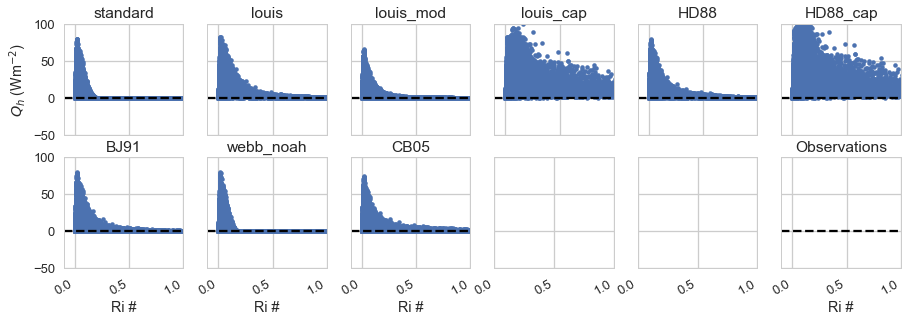

In [8]:
########
# Sensible
os.chdir(dir_print)
fig, axes = plt.subplots(2, 6, sharey=True, figsize=(15, 5))
Ri = Mtower['RiBulk_10m'][ind_10m]
axes = axes.flatten()
Qmax = 100
Qmin = -50
RiMax = 1.
RiMin = -0.1

for n, stab in enumerate(stab_titles):
    d = out_titles[stab]
    ax = axes[n]
    ax.plot(Ri, sensible_10m[d], '.')
    ax.plot([RiMin, RiMax], [0, 0], 'k--')
    ax.set_xlim(RiMin, RiMax)
    ax.set_ylim(Qmin, Qmax)
    ax.set_xlabel('Ri #')
    ax.set_title(d)

ax = axes[0]
ax.set_ylabel('$Q_h$ (Wm$^{-2}$)')

ax = axes[-1]
# ax.plot(Ri, Mtower[''.SensFlux[ind], '.')
ax.plot([RiMin, RiMax], [0, 0], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlim(RiMin, RiMax)
ax.set_xlabel('Ri #')
ax.set_title('Observations')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible_Ri.pdf')

NameError: name 'support' is not defined

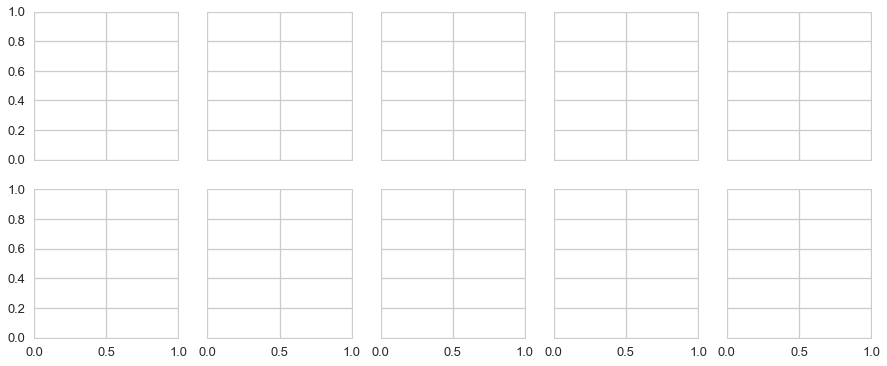

In [9]:
########
# Model Sensible vs Obs Sensible 
os.chdir(dir_print)
fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(15, 6))
axes = axes.flatten()
Qmax = 100
Qmin = -50

for n, stab in enumerate(stab_titles):
    d = out_titles[stab]
    ax = axes[n]
    ax.plot(support.SensFlux[ind], sensible[d], '.', label=stab)
    ax.plot([Qmin, Qmax],[Qmin, Qmax], '--k')
    ax.set_ylim(Qmin, Qmax)
    ax.set_xlim(Qmin, Qmax)
    ax.set_xlabel('Obs. $Q_h$ (Wm$^{-2}$)')
    ax.set_title(stab)
    
    if ax.is_first_col():
        ax.set_ylabel('Model $Q_h$ (Wm$^{-2}$)')

fig.autofmt_xdate()
# fig.savefig('ATMS547.OfflineTurb.SNQ_wind2ms.Sensible.pdf')

## Use all turbulence data when snow is present

In [ ]:
## Select only turbulence data that meets the assumptions for eddy-covariance
ind = np.nonzero ((support.SP == 1).values &
                  (~(np.isnan(support.SensFlux)).values |
                   ~(np.isnan(support.LatFlux)).values))
snoqTurbObs = xr.Dataset({'sensible' : (['time'], support.SensFlux[ind].values),
                          'latent' : (['time'], support.LatFlux[ind].values)},
                         coords={'time': support.time[ind]})